### Classification using LSTM - using Tensorflow

### Library Imports

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Importing data
dataset = pd.read_csv('/content/drive/MyDrive/lstm_data/train.tsv', sep='\t')

### Cleaning the Phrases

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

# From the first assignment
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [10]:
 #############################################################################################  
 # Clean all the reviews in the dataset using the clean_text function provided above         # 
 ############################################################################################# 
 
dataset['cleaned_review'] = dataset['Phrase'].apply(clean_text)


In [11]:
 #####################################################################
 # print head of the "CLEANED" data frame with help of head function # 
 #####################################################################
dataset.head()

,PhraseId,SentenceId,Phrase,Sentiment,cleaned_review
0,1,1,A series of escapades demonstrating the adage ...,1,series escapade demonstrating adage good goose...
1,2,1,A series of escapades demonstrating the adage ...,2,series escapade demonstrating adage good goose
2,3,1,A series,2,series
3,4,1,A,2,
4,5,1,series,2,series


### Splitting the dataset and Encoding Labels (2 Points)

Spliting data: <br> 
80% for the training and the remaining 20% for validation.

Encoding Labels: <br>
Encode labels as negative and positive as 0 and 1 respectively


In [13]:
#################################################################################
# Split the data using the sklearn module                                       #
# 80% for the training and the remaining 20% for validation                     #
#################################################################################
X = dataset['cleaned_review']
y = dataset['Sentiment']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20)

In [14]:
#################################################################################
# Initialize label encoder from sklearn module                                  #
# fit on train labels and transform both train and validation labels            #
#################################################################################
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)

### Pre-Processing The Text (5 Points)
 

In [15]:
# You can use the modules given below
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

###############################################################################  
# Fit your tokenizer on the training reviews                                  #
###############################################################################
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


#################################################################################################
# The word_index dictionary assigns a unique index to each unique word present in the training  #
# reviews.                                                                                      #
#                                                                                               #
# Create the word_index dictionary using the tokenizer                                          #
# Find the vocabulary of your training reviews                                                  #
#################################################################################################

word_index = tokenizer.word_index

vocabulary = len(word_index) + 1


#################################################################################################
# Convert the reviews in the dataset to their index form by using a function available          #
# with the tokenizer                                                                            #
#################################################################################################
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)


#################################################################################################
# Pad the the training and validation sequences so all of them have the same length             # 
#################################################################################################
X_train = pad_sequences(train_sequences, maxlen = 200)
X_val = pad_sequences(val_sequences, maxlen = 200)
# maxlen which is the maximum length of one review we will use for our training

print('Vocabulary : {}'.format(vocabulary))

Vocabulary : 14917


In [16]:
X_train

array([[    0,     0,     0, ...,    58, 10442,   293],
       [    0,     0,     0, ...,  8602,  7270,     1],
       [    0,     0,     0, ...,     0,  7271,    60],
       ...,
       [    0,     0,     0, ...,  3747,  4414,  1101],
       [    0,     0,     0, ...,     0,  3339, 11007],
       [    0,     0,     0, ...,   396,    65,     1]], dtype=int32)

### Using glove vectors for embedding 

GloVe vectors capture both global statistics and local statistics of a corpus. We use GloVe to convert words to embeddings in the vector space based on their semantics. 

We will be using the 200-dimensional GloVe vectors for the task at hand.


In [17]:
glove_dictionary = {}
with open('/content/drive/MyDrive/lstm_data/glove.6B.200d.txt') as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

In [18]:
 # All the words which are not in the GloVe dictionary will be assigned a zero vector.

embedding_matrix = np.zeros((vocabulary, 200))

######################################################################
# The glove_dictionary contains words vs their respective embeddings #
#                                                                    #
# Create the embedding matrix using the glove_dictionary             #
######################################################################
for word, i in word_index.items():
  if glove_dictionary.get(word) is not None:
    embedding_matrix[i,:] = glove_dictionary.get(word)


In [19]:
embedding_matrix.shape

(14917, 200)

### Creating The Model

In [37]:
y_train = pd.get_dummies(y_train)
y_val = pd.get_dummies(y_val)

In [48]:
import tensorflow as tf
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Bidirectional
from tensorflow.keras.layers import Embedding
tf.random.set_seed(42)

######################################################
# Complete this linear model in tensorflow           #
######################################################

def build_model(embedding_matrix):

  ''' 
  Arguments:
    embedding_matrix : a matrix with the corresponding embeddings
    of all words.

  Returns:
    The LSTM model that you created.
  '''
  
  model = tf.keras.Sequential()

  # layer 1 : add embedding layer
  # The embedding layer maps the words to their embedding vectors from the embedding matrix
  model.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = 200, 
                      weights = [embedding_matrix], input_length = 200, 
                      trainable = False))


  # add Bidirectional LSTM Layer 
  model.add(Bidirectional(LSTM(64)))
  model.add(Dense(64, activation = 'relu'))

  model.add(Dense(5, activation = 'softmax'))
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', 
                metrics = ['AUC', 'Precision', 'Recall', 'accuracy'])
  
  return model

In [49]:
model = build_model(embedding_matrix)
#######################################################################################################
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), 
                    epochs = 10, batch_size = 32)

Epoch 1/10
3902/3902 [==============================] - 811s 207ms/step - loss: 0.3308 - auc: 0.8772 - precision: 0.6940 - recall: 0.4539 - accuracy: 0.6014 - val_loss: 0.3142 - val_auc: 0.8919 - val_precision: 0.7062 - val_recall: 0.4991 - val_accuracy: 0.6258
Epoch 2/10
3902/3902 [==============================] - 802s 206ms/step - loss: 0.3057 - auc: 0.8987 - precision: 0.7012 - recall: 0.5272 - accuracy: 0.6378 - val_loss: 0.3026 - val_auc: 0.9012 - val_precision: 0.6978 - val_recall: 0.5510 - val_accuracy: 0.6454
Epoch 3/10
3902/3902 [==============================] - 806s 207ms/step - loss: 0.2904 - auc: 0.9102 - precision: 0.7095 - recall: 0.5742 - accuracy: 0.6613 - val_loss: 0.3009 - val_auc: 0.9036 - val_precision: 0.6838 - val_recall: 0.5890 - val_accuracy: 0.6499
Epoch 4/10
3902/3902 [==============================] - 806s 207ms/step - loss: 0.2789 - auc: 0.9181 - precision: 0.7193 - recall: 0.6065 - accuracy: 0.6798 - val_loss: 0.2963 - val_auc: 0.9068 - val_precision: 0.6

In [50]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 200)          2983400   
                                                                 
 bidirectional_13 (Bidirecti  (None, 128)              135680    
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 5)                 325       
                                                                 
Total params: 3,127,661
Trainable params: 144,261
Non-trainable params: 2,983,400
_________________________________________________________________


In [52]:
pred = model.predict(X_val)
y_pred = pd.DataFrame(pred).idxmax(axis=1)
y_vals = y_val.idxmax(axis=1)

976/976 [==============================] - 69s 71ms/step


In [68]:
from sklearn.metrics import classification_report
report = classification_report(y_vals,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.52      0.34      0.42      1432
           1       0.54      0.52      0.53      5411
           2       0.73      0.80      0.77     15940
           3       0.57      0.54      0.56      6644
           4       0.55      0.39      0.46      1785

    accuracy                           0.65     31212
   macro avg       0.58      0.52      0.54     31212
weighted avg       0.65      0.65      0.65     31212



### Plotting Accuracy and Losses (5 Points)
 




/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

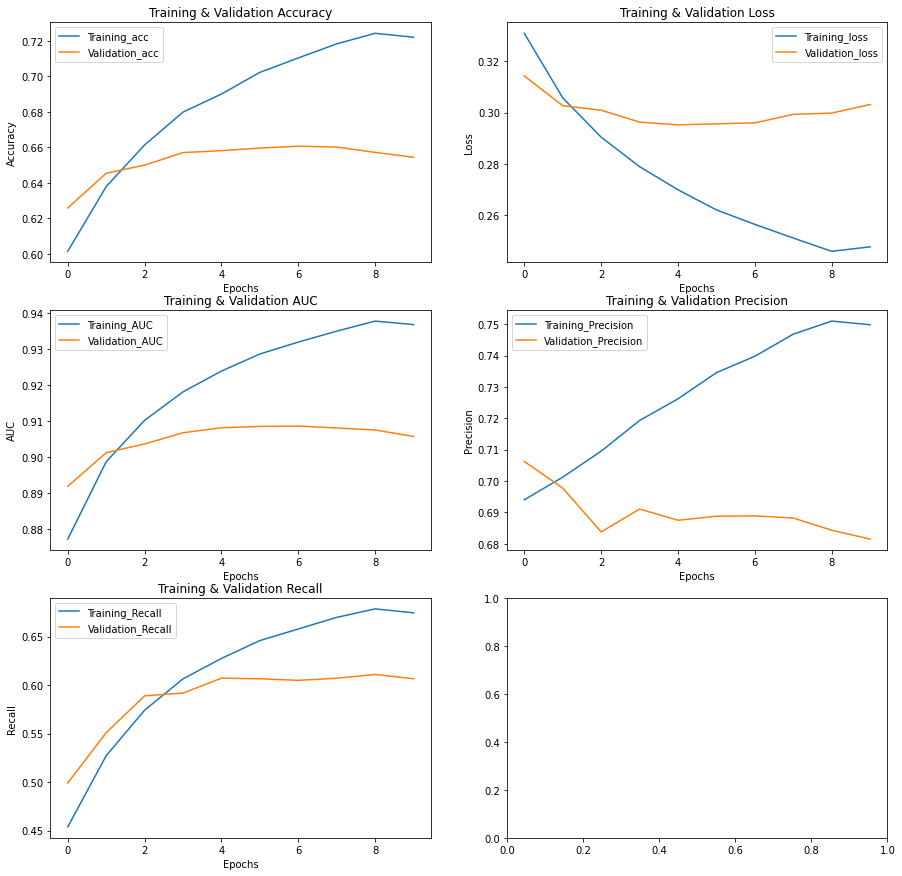

In [54]:
####################################
# PLOT :                           #
# train loss vs val loss           #
# train auc vs val auc             #
# train recall vs val recall       #
# train precision vs val precision #
# train accuracy vs val accuracy   #
####################################
fig, axes = plt.subplots(3, 2, figsize = (15, 15))

epochs = list(range(0, 10))

sns.lineplot(epochs, history.history['accuracy'], 
             label = 'Training_acc', ax = axes[0][0])
sns.lineplot(epochs, history.history['val_accuracy'], 
             label = 'Validation_acc', ax = axes[0][0])

sns.lineplot(epochs, history.history['loss'], 
             label = 'Training_loss', ax = axes[0][1])
sns.lineplot(epochs, history.history['val_loss'], 
             label = 'Validation_loss', ax = axes[0][1])

sns.lineplot(epochs, history.history['auc'], 
             label = 'Training_AUC', ax = axes[1][0])
sns.lineplot(epochs, history.history['val_auc'], 
             label = 'Validation_AUC', ax = axes[1][0])

sns.lineplot(epochs, history.history['precision'], 
             label = 'Training_Precision', ax = axes[1][1])
sns.lineplot(epochs, history.history['val_precision'], 
             label = 'Validation_Precision', ax = axes[1][1])

sns.lineplot(epochs, history.history['recall'], 
             label = 'Training_Recall', ax = axes[2][0])
sns.lineplot(epochs, history.history['val_recall'], 
             label = 'Validation_Recall', ax = axes[2][0])

axes[0][0].set(xlabel = 'Epochs', ylabel = 'Accuracy')
axes[0][0].set_title("Training & Validation Accuracy")

axes[0][1].set(xlabel = 'Epochs', ylabel = 'Loss')
axes[0][1].set_title("Training & Validation Loss")

axes[1][0].set(xlabel = 'Epochs', ylabel = 'AUC')
axes[1][0].set_title("Training & Validation AUC")

axes[1][1].set(xlabel = 'Epochs', ylabel = 'Precision')
axes[1][1].set_title("Training & Validation Precision")

axes[2][0].set(xlabel = 'Epochs', ylabel = 'Recall')
axes[2][0].set_title("Training & Validation Recall")

plt.show()
